In [179]:
#Importing libraries
from matplotlib import pyplot as plt
import cv2
import numpy as np
import os
import random
import shutil
from PIL import Image

x_dim = 32
y_dim = 32

In [180]:
#Splitting the dataset into train and test folders. Please create test and train dir in the given path before running this.

def delete_contents(folder): # function to delete the files in a dir
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

def get_files_from_folder(path): #Returns all the files and folders in a given path.

    files = os.listdir(path)
    return np.asarray(files)

def main(path_to_data, path_to_test_data, path_to_train_data, train_ratio):
    # get dirs
    _, dirs, _ = next(os.walk(path_to_data))

    # calculates how many train data per class
    data_counter_per_class = np.zeros((len(dirs)))
    for i in range(len(dirs)):
        path = os.path.join(path_to_data, dirs[i])
        files = get_files_from_folder(path)
        data_counter_per_class[i] = len(files)
    test_counter = np.round(data_counter_per_class * (1 - train_ratio))
    train_counter = np.round(data_counter_per_class * train_ratio)

    # transfers files
    for i in range(len(dirs)):
        path_to_original = os.path.join(path_to_data, dirs[i])

        #creates dir
        # Kavya : better if checked outside the for loop
        if not os.path.exists(path_to_test_data):
            os.makedirs(path_to_test_data)
        if not os.path.exists(path_to_train_data):
            os.makedirs(path_to_train_data)
            
        files = get_files_from_folder(path_to_original)
        random.shuffle(files)
        # moves data
        for j in range(int(test_counter[i])):
            dst = os.path.join(path_to_test_data, files[j])
            src = os.path.join(path_to_original, files[j])
            shutil.copy(src, dst)
        #files = get_files_from_folder(path_to_original)
        #random.shuffle(files)
        for j in range(int(test_counter[i]),len(files)):
            dst = os.path.join(path_to_train_data, files[j])
            src = os.path.join(path_to_original, files[j])
            shutil.copy(src, dst)
if __name__ == "__main__":
    delete_contents('./train')
    delete_contents('./test')
    main('./Images_face95','./test','./train',0.7)

In [181]:
#Path for the training images

Path = './train/'
files = os.listdir(Path)
files.sort()

In [182]:
#Converting each image to Grayscale and appending the data to images

images = []

for name in files:
    temp = cv2.imread('./train/'+name)
    temp = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
    temp = cv2.resize(temp, (x_dim,y_dim), interpolation = cv2.INTER_AREA)
    images.append(temp.flatten())
        
# total number of images considered : 360 - 5 of each person
# images converted to grayscale of size : (100,100)

# images : rows - 360
#          columns - 100*100 = 10000
# images.shape : (360,10000)

# temp.shape : (100, 100)

In [183]:
# Calculating the mean of images

images = np.array(images)
image_mean = images.mean(axis = 0)
images = images - image_mean
images = images.T
# transpose of images taken to find eigen vectors of matrix A'A

# image_mean.shape : (100000,)
# images.shape : (10000, 360)

In [184]:
#SVD function
#u is the basis of eigen faces

u,s,v = np.linalg.svd(images, full_matrices=False)

# u.shape : (10000, 360)
# There are 360 eigen faces currently

(1008,)


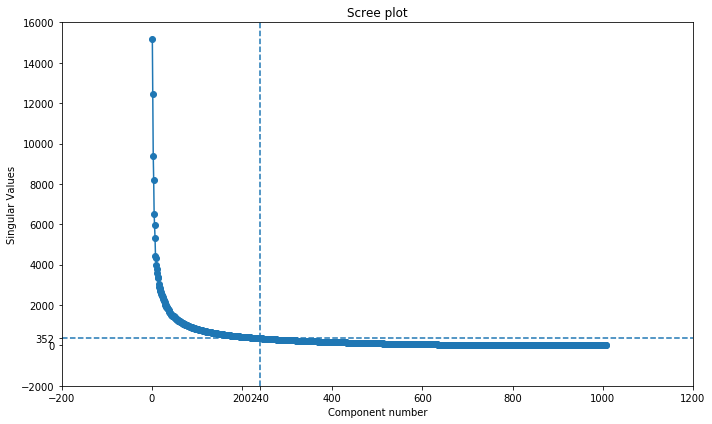

In [185]:
print(s.shape)
x1 = range(1,s.shape[0]+1)
y1 = s
#Plot a line graph
fig, ax1 = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(x1, y1, marker='o')
ax1.axhline(y=s[240], xmin=0, xmax=images.shape[1], ls='--')
ax1.axvline(x=240, ymin=0, ymax=s[240], ls='--')
x_ticks = np.append(ax1.get_xticks(), 240)
y_ticks = np.append(ax1.get_yticks(), s[240])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_title("Scree plot")
ax1.set(xlabel="Component number",ylabel="Singular Values")
fig.tight_layout()
plt.show()

In [186]:
#dropping the unwanted columns in U matrix to form the feature matrix.
u = u[:,:240]

In [187]:
#Dot product of all the images and U matrix to find the projection co-efficients

dot_train = np.empty(shape = (u.shape[1], images.shape[1]),  dtype=np.int8) #360 by 360
temp = np.empty(shape = (1, u.shape[1]),  dtype=np.int8) #1 by 360

# dot_train.shape : (120, 720)
# temp.shape : (1, 120)
# images.shape : (10000, 720)

for i in range(images.shape[1]):    # i from 0 to 360
    for c in range(u.shape[1]):    # c from 0 to 360
        temp[0,c] = np.sum(images[:,i] * u[:,c])
        
    dot_train[:, i] = temp[:]

In [188]:
# REPEAT THE EXECUTION OF CODE BELOW FOR NEW INPUT

In [189]:
#Path for the training images

Path = './test/'
tfiles = os.listdir(Path)
tfiles.sort()

In [190]:
test_images = []

for name in tfiles:
    temp = cv2.imread('./test/'+name)
    temp = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
    temp = cv2.resize(temp, (x_dim,y_dim), interpolation = cv2.INTER_AREA)
    test_images.append(temp.flatten())

In [191]:
#Substracting mean
test_images = np.array(test_images)
test_images = test_images - image_mean
test_images = test_images.T

In [192]:
#Dot product of test image and U matrix

dot_test = np.empty(shape = (u.shape[1], test_images.shape[1]), dtype=np.int8)
temp = np.empty(shape = (1, u.shape[1]),  dtype=np.int8)
    
for i in range(test_images.shape[1]):    # i from 0 to 432
    for c in range(u.shape[1]):    # c from 0 to 240
        temp[0,c] = np.sum(test_images[:,i] * u[:,c])
    dot_test[:, i] = temp[:]

In [193]:
# calculating the variation between input image and test images
answer = np.empty(shape=(dot_train.shape[1],dot_test.shape[1]))
for i in range(dot_test.shape[1]):
    sub = np.empty(shape = (u.shape[1], dot_train.shape[1]), dtype=np.int8)
    for col in range(dot_train.shape[1]):
        sub[:,col] = dot_train[:,col] - dot_test[:,i]
    for c in range(sub.shape[1]):    
        answer[c,i] = np.linalg.norm(sub[:,c])

In [194]:
def min_index(temp):
    m = 0
    for i in range(len(temp)):
        if temp[i]<temp[m]:
            m = i
    return m

# Kavya : using sort() function would be more efficient.

In [195]:
# FACE RECOGNITION
temp_ans = np.empty(shape=(answer.shape[1],),dtype=int)
temp = np.empty(shape=(answer.shape[0],))
for i in range(0,answer.shape[1]):
    temp = answer[:,i]
    temp_ans[i] = min_index(temp)

In [196]:
right = 0
total = test_images.shape[1]
for i in range(temp_ans.shape[0]):
    if tfiles[i].split(".")[0] == files[temp_ans[i]].split(".")[0]:
        right+=1
    else:
        print(tfiles[i].split(".")[0],files[temp_ans[i]].split(".")[0])
eff = (right/total)*100
print("Efficiency: ",eff,"%")

adhast matth
ajbake riphil
apapou matth
apdavi matth
apdavi mkosto
apdavi cywan
ardper cywan
boylee wjhugh
boylee cywan
bschap cywan
cadugd sapere
cadugd cywan
cdlarg ldgodd
cdlarg thgear
cdlarg cywan
cdlarg sjpalm
cfloro cywan
cladam sherbe
cladam ardper
cywan ldgodd
dakram namart
damvo namart
damvo llambr
darda theoc
dfhodd ldgodd
dgemen mkosto
gsmall cladam
gsmall cladam
gsmall theoc
gstamo matth
hcarpe gstamo
hcarpe matth
howar ardper
hsgrim wjhugh
hsgrim matth
ijfran dgemen
isbald matth
jross namart
jserai mkosto
jserai apapou
jshea matth
jshea simm
kmbald jshea
labenm cywan
lidov dgemen
llambr wjhugh
mdchud awjsud
mizli sherbe
padnor matth
pajaco rjdunc
papad sdwall
papad sdwall
papad cywan
pears matth
pears matth
pears virvi
pears awjsud
pjrand awjsud
rhnorm sdwall
riphil cywan
riphil matth
rjdunc ldgodd
sapere namart
sgjday mkosto
sherbe jbierl
simm cfloro
simm pcfry
sirmcb sdwall
sjcutt sdwall
sjcutt sdwall
sjkill dfhodd
sjkill dfhodd
sjkill cfloro
sjpalm rhnorm
sjpalm kouri
s